In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
import pickle

RANDOM_STATE = 123
TEST_SIZE = 0.25

In [2]:
pd.options.display.max_columns = None

In [3]:
heart_train = pd.read_csv('heart_train.csv')
heart_train.head(5)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Описание столбцов:

*   Unnamed:0 - колонка дублирует индекс
*   Age - возвраст пациента
*   Cholesterol - уровень холестерина в крови
*   Heart rate - частота сердцебиения
*   Diabetes - в данном случае подразумевается является ли пациент диабетиком
*   Family History - вероятней всего подразумевается, наличие сердечных заболеваний в семье
*   Smoking - курит ли пациент
*   Obesity - страдает ли пациент ожирением
*   Alcohol Consumption - употреляет ли пациент алкоголь
*   Exercise Hours Per Week - интенсивные физические упражения (часов в неделю)
*   Diet - тип диеты
*   Previous Heart Problems - имелись ли проблемы с сердцем ранее
*   Medication Use - принимает ли пациент медикаменты
*   Stress level - уровень стресса
*   Sedentary Hours Per Day - сидячее положение (часов в день)
*   Income - доход
*   BMI - индекс массы тела
*   Triglycerides - биохимия крови (норма 0,2–1,7 ммоль/л)
*   Physical Activity Days Per Week - физическая активность (дней в неделю)
*   Sleep Hours Per Day - количества сна (часов в день)
*   Heart Attack Risk - риск поражения сердца (целевой признак)
*   Blood sugar - уровень сахара в крови
*   CK-MB - биохимия крови (норма 0–5 нг/мл)
*   Troponin - биохимия крови
*   Gender - пол пациента (мужской/женский)
*   Systolic blood pressure - верхнее давление
*   Diastolic blood pressure - нижнее давление
*   id - уникальный номер пациента













In [4]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [5]:
heart_train.columns

Index(['Unnamed: 0', 'Age', 'Cholesterol', 'Heart rate', 'Diabetes',
       'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption',
       'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
       'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar',
       'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure',
       'Diastolic blood pressure', 'id'],
      dtype='object')

In [6]:
heart_train.columns = [col.lower().replace(' ', '_').replace(':', '').replace('-', '_') for col in heart_train.columns]

In [7]:
heart_train.rename(columns={'heart_attack_risk_(binary)': 'heart_attack_risk'}, inplace=True)

In [8]:
heart_train.columns

Index(['unnamed_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk', 'blood_sugar', 'ck_mb',
       'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [9]:
binary_features = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use']

In [10]:
for i in binary_features:
  print(heart_train[i].unique())

[ 1.  0. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 0.  1. nan]


In [11]:
heart_train.describe()

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk,blood_sugar,ck_mb,troponin,systolic_blood_pressure,diastolic_blood_pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


`age, cholesterol, heart_rate, exercise_hours_per_week, sedentary_hours_per_day, income, bmi, triglycerides, sleep_hours_per_day, blood_sugar, ck_mb, troponin, systolic_blood_pressure, diastolic_blood_pressure` - к данным признакам применен метод масштабирования

In [12]:
# numeric_featutes = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
#                     'sleep_hours_per_day', 'blood_sugar', 'ck_mb','troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']

In [13]:
numeric_features = ['diet', 'stress_level', 'physical_activity_days_per_week']

In [14]:
for i in numeric_features:
  print(heart_train[i].unique())

[1 2 0 3]
[ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
[ 3.  2.  0.  5.  6.  4.  7. nan  1.]


In [15]:
heart_train.isna().sum()

unnamed_0                            0
age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk                    0
blood_sugar                          0
ck_mb                                0
troponin                             0
gender                               0
systolic_blood_pressure  

In [16]:
# Проверим данные на дубликаты
heart_train.duplicated().sum()

0

In [17]:
heart_train.columns[heart_train.isna().any()]

Index(['diabetes', 'family_history', 'smoking', 'obesity',
       'alcohol_consumption', 'previous_heart_problems', 'medication_use',
       'stress_level', 'physical_activity_days_per_week'],
      dtype='object')

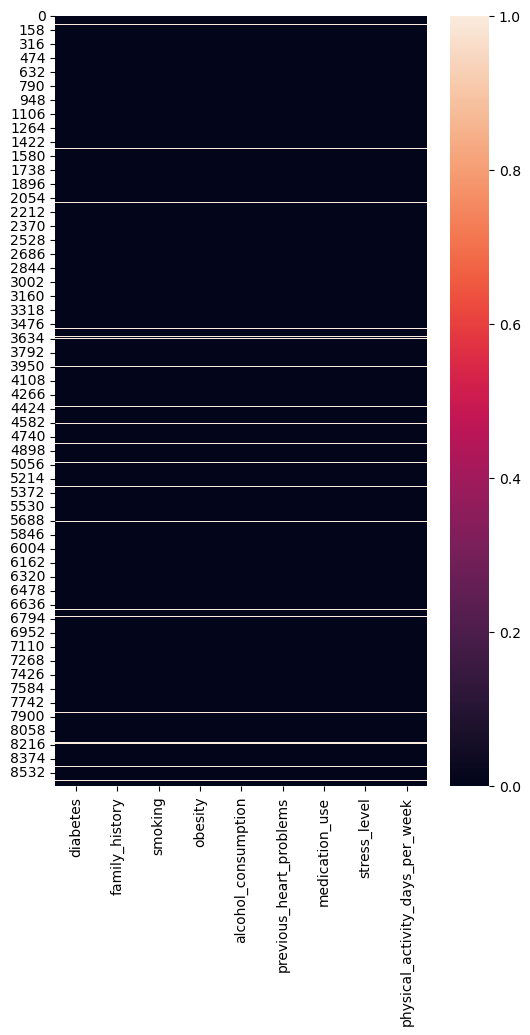

In [18]:
plt.figure(figsize=(6,10))
sns.heatmap(heart_train[heart_train.columns[heart_train.isna().any()]].isna())
plt.show()

Похоже, что в данных колонках пропуски присутствуют в одних и тех же строках.

In [19]:
heart_train[heart_train.isna().any(axis=1)]

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,8461,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140,9455
8509,8509,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070,9506
8536,8536,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698,9474
8619,8619,0.606742,0.49978,0.059578,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.156126,0.057692,0.000583,0.0,0.387097,0.500000,9467


In [20]:
# Доля пропусков от общего количества данных
heart_train.smoking.isna().sum() / heart_train.shape[0]

0.027979274611398965

Доля пропусков от общего количества данных составляет меньше 3%, их удаление существенно не повлияет на результат исследования

In [21]:
for i in heart_train.columns[heart_train.isna().any()]:
  print(heart_train[heart_train.isna().any(axis=1)][i].value_counts(dropna=False))

diabetes
NaN    243
Name: count, dtype: int64
family_history
NaN    243
Name: count, dtype: int64
smoking
NaN    243
Name: count, dtype: int64
obesity
NaN    243
Name: count, dtype: int64
alcohol_consumption
NaN    243
Name: count, dtype: int64
previous_heart_problems
NaN    243
Name: count, dtype: int64
medication_use
NaN    243
Name: count, dtype: int64
stress_level
NaN    243
Name: count, dtype: int64
physical_activity_days_per_week
NaN    243
Name: count, dtype: int64


Предположение подтвердилось, колонки с пропущенными значениями имеют пропуски в одних и тех же строках.

In [22]:
heart_train[heart_train.isna().any(axis=1)]['income'].value_counts()

income
0.494889    243
Name: count, dtype: int64

In [23]:
heart_train[heart_train.isna().any(axis=1)]['cholesterol'].value_counts()

cholesterol
0.49978    243
Name: count, dtype: int64

In [24]:
heart_train[heart_train.isna().any(axis=1)]['cholesterol'].value_counts()

cholesterol
0.49978    243
Name: count, dtype: int64

In [25]:
heart_train[heart_train.isna().any(axis=1)]['bmi'].value_counts()

bmi
0.494774    243
Name: count, dtype: int64

In [26]:
heart_train[heart_train.isna().any(axis=1)]['triglycerides'].value_counts()

triglycerides
0.503603    243
Name: count, dtype: int64

In [27]:
heart_train[heart_train.isna().any(axis=1)]['gender'].value_counts()

gender
1.0    156
0.0     87
Name: count, dtype: int64

In [28]:
heart_train['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

Очень похоже, что строки с этими данными попали в датасет в результате какой-то технической ошибки.

In [29]:
heart_train.dropna(inplace=True)

In [30]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed_0                        8442 non-null   int64  
 1   age                              8442 non-null   float64
 2   cholesterol                      8442 non-null   float64
 3   heart_rate                       8442 non-null   float64
 4   diabetes                         8442 non-null   float64
 5   family_history                   8442 non-null   float64
 6   smoking                          8442 non-null   float64
 7   obesity                          8442 non-null   float64
 8   alcohol_consumption              8442 non-null   float64
 9   exercise_hours_per_week          8442 non-null   float64
 10  diet                             8442 non-null   int64  
 11  previous_heart_problems          8442 non-null   float64
 12  medication_use           

Изменим тип данных

In [31]:
for i in binary_features:
    heart_train[i] = heart_train[i].astype('int')

In [32]:
for i in numeric_features:
    heart_train[i] = heart_train[i].astype('int')

In [33]:
heart_train['heart_attack_risk'] = heart_train['heart_attack_risk'].astype('int')

# EDA

In [34]:
matrix_corr = heart_train.drop(['id', 'gender', 'unnamed_0'], axis=1)

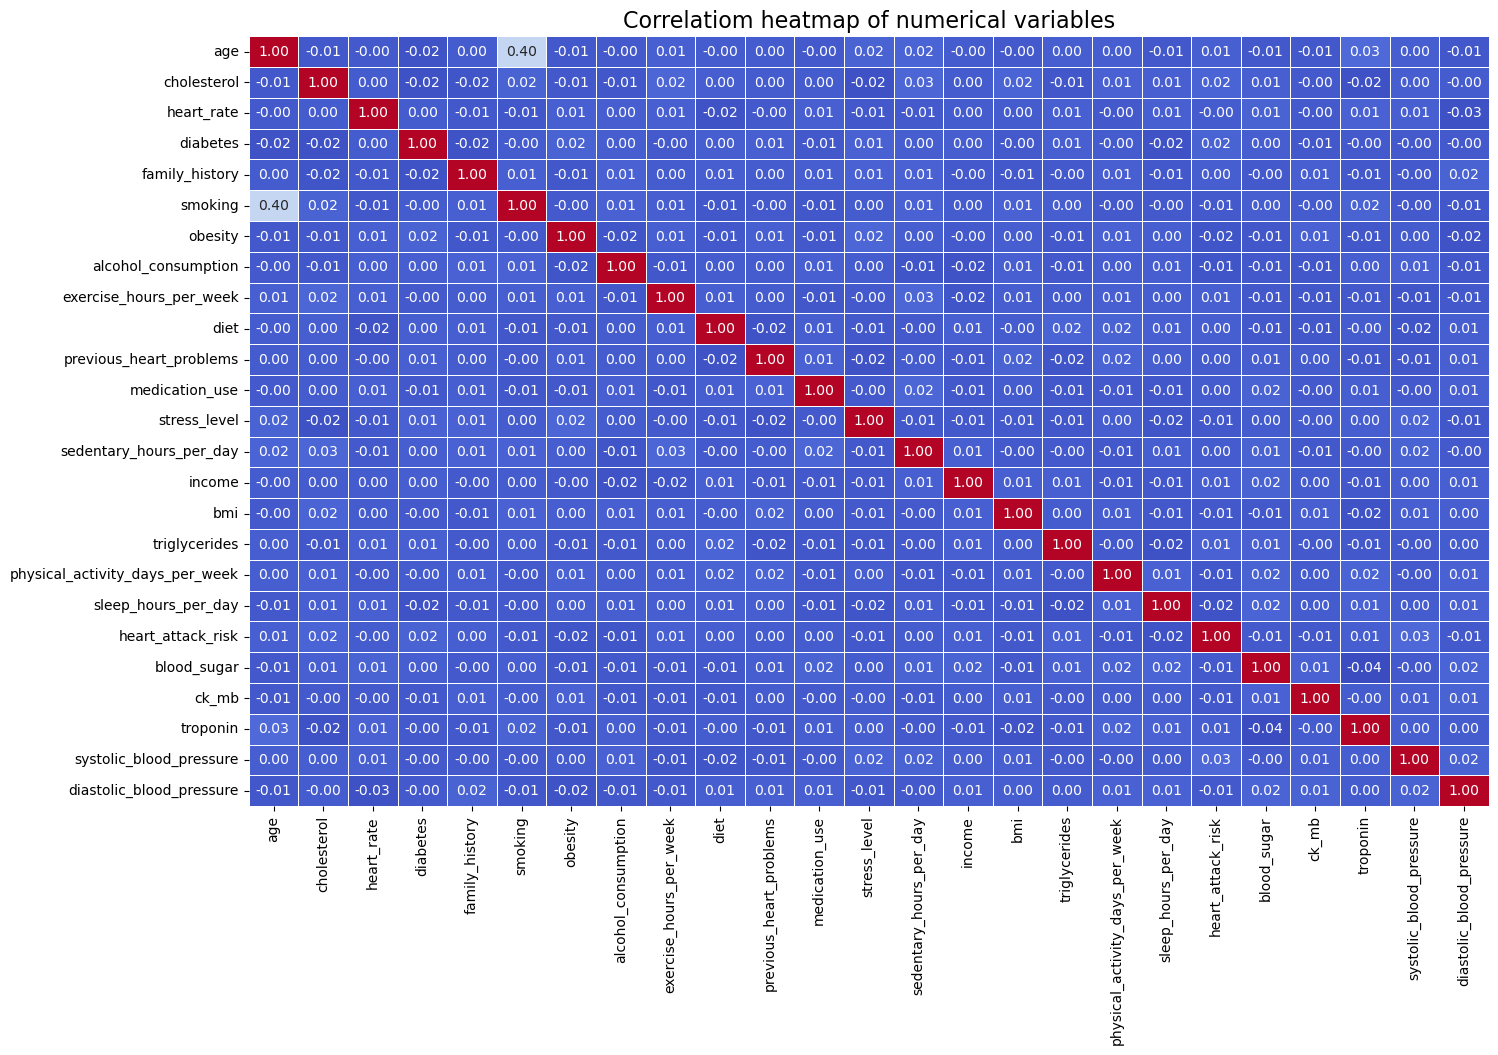

In [35]:
plt.figure(figsize=(16,10))
sns.heatmap(matrix_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False, linewidths=0.5)
plt.title("Correlatiom heatmap of numerical variables", fontsize=16)
plt.show()

In [36]:
# Функция построения графиков для категориальных признаков
def analyze_obj(df:pd.DataFrame, column:str):
    """
    Анализирует столбец датафрейма, подсчитывает количество уникальных значений и моду
    Строит круговую диаграмму

    Параметры:
    - df: pd.DataFrame, входной датафрейм
    - column: str, колонка для анализа

    Вывод:
    - информация о количестве уникальных значений и моде
    - столбчатая диаграмма
    """

    # Подсчёт уникальных значений
    count_values = df[column].value_counts(normalize=True)

    # Поиск моды
    mode_value = df[column].mode()[0]

    print(f'Кол-во уникальных значений: {count_values}')
    print(f'Мода: {mode_value}')

    # Построение столбчатой диаграммы
    plt.figure(figsize=(8, 5))
    sns.set(style='whitegrid')
    sns.countplot(df, x=column, hue='heart_attack_risk', stat='percent')
    plt.ylabel('Количество')
    plt.xlabel(f'{column}')
    plt.title(f'Распределение исследуемого признака {column}')

    return

Кол-во уникальных значений: heart_attack_risk
0    0.643094
1    0.356906
Name: proportion, dtype: float64
Мода: 0


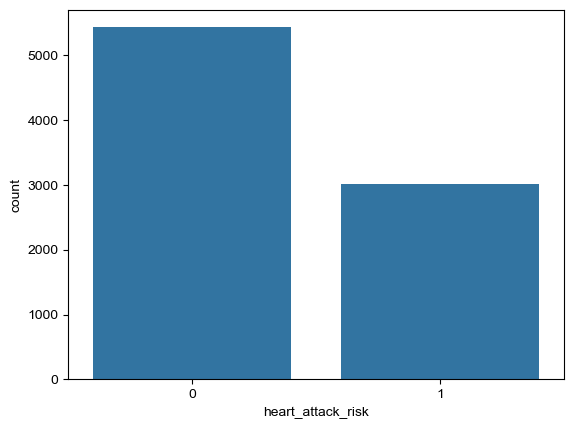

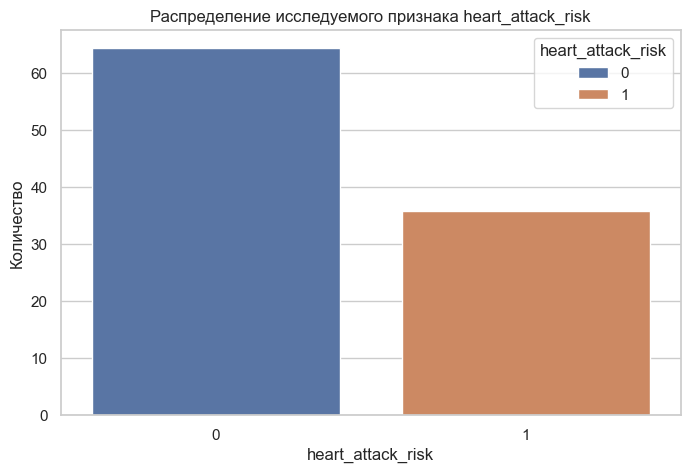

In [37]:
sns.countplot(heart_train, x='heart_attack_risk', stat='count');
analyze_obj(heart_train, 'heart_attack_risk')

Кол-во уникальных значений: diabetes
1    0.652097
0    0.347903
Name: proportion, dtype: float64
Мода: 1


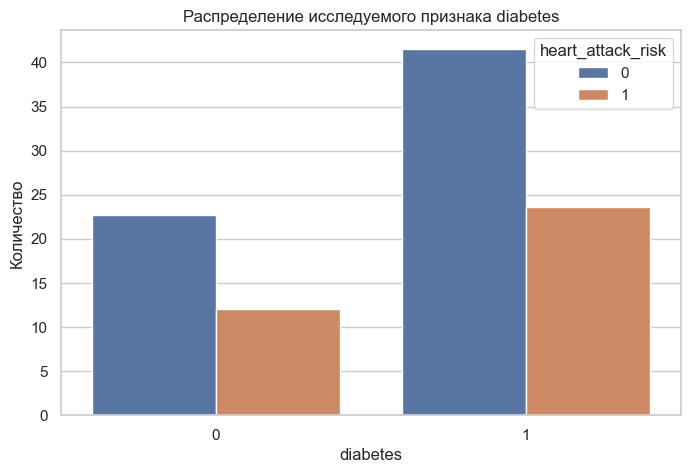

In [38]:
analyze_obj(heart_train, 'diabetes')

Кол-во уникальных значений: family_history
0    0.510424
1    0.489576
Name: proportion, dtype: float64
Мода: 0


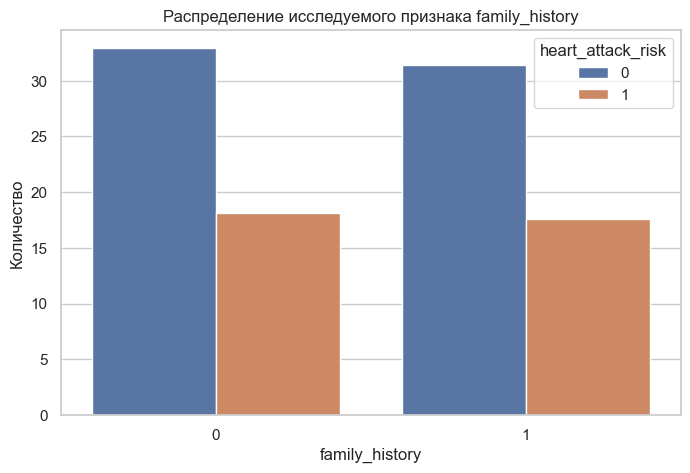

In [39]:
analyze_obj(heart_train, 'family_history')

Кол-во уникальных значений: smoking
1    0.902867
0    0.097133
Name: proportion, dtype: float64
Мода: 1


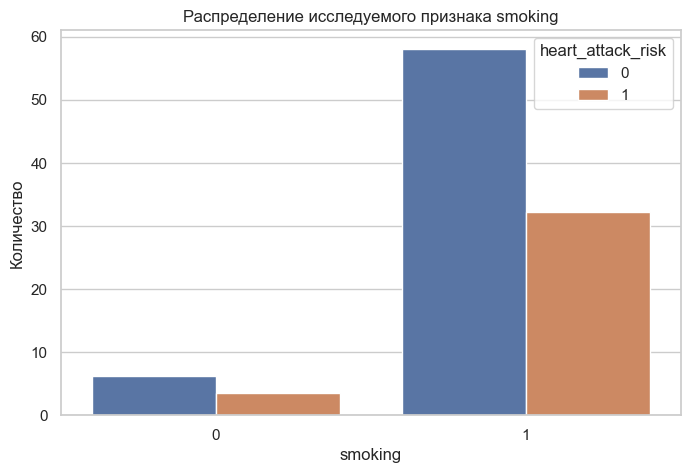

In [40]:
analyze_obj(heart_train, 'smoking')

Кол-во уникальных значений: obesity
0    0.501658
1    0.498342
Name: proportion, dtype: float64
Мода: 0


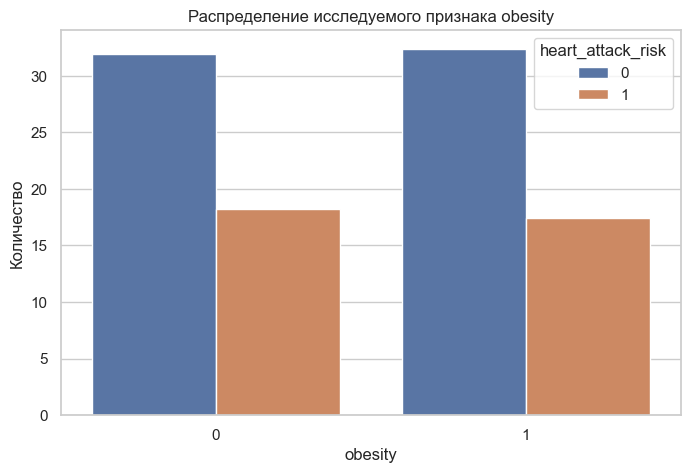

In [41]:
analyze_obj(heart_train, 'obesity')

Кол-во уникальных значений: alcohol_consumption
1    0.60199
0    0.39801
Name: proportion, dtype: float64
Мода: 1


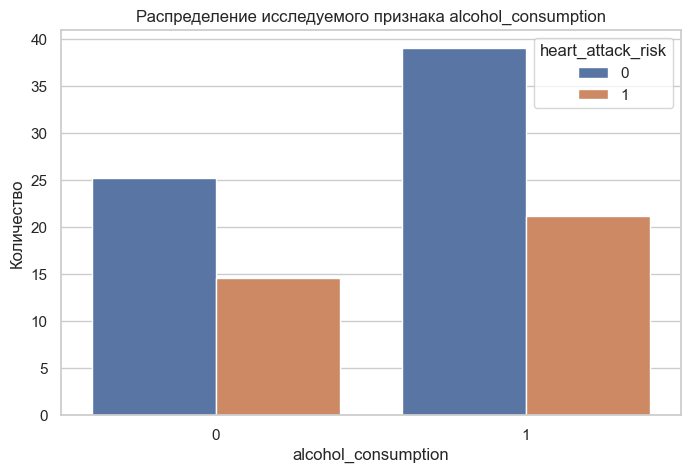

In [42]:
analyze_obj(heart_train, 'alcohol_consumption')

Кол-во уникальных значений: previous_heart_problems
0    0.50462
1    0.49538
Name: proportion, dtype: float64
Мода: 0


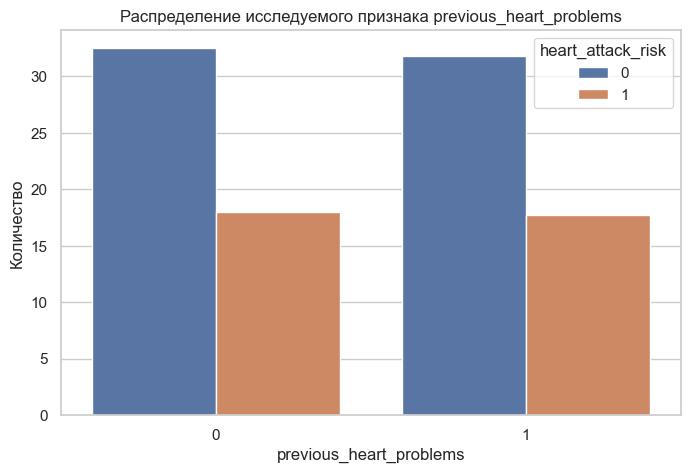

In [43]:
analyze_obj(heart_train, 'previous_heart_problems')

Кол-во уникальных значений: medication_use
1    0.501185
0    0.498815
Name: proportion, dtype: float64
Мода: 1


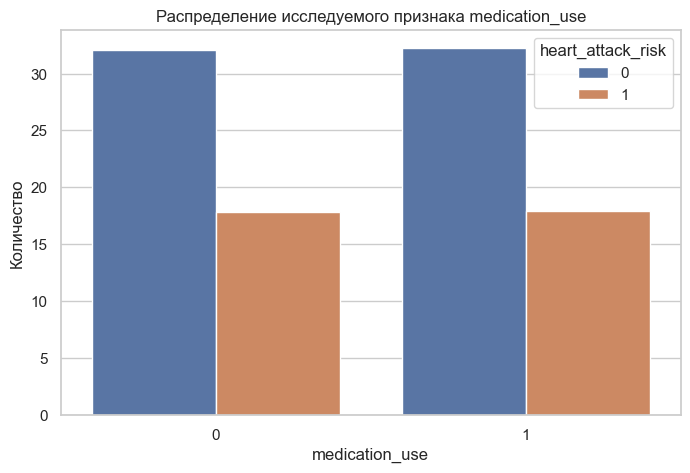

In [44]:
analyze_obj(heart_train, 'medication_use')

<Axes: xlabel='diet', ylabel='count'>

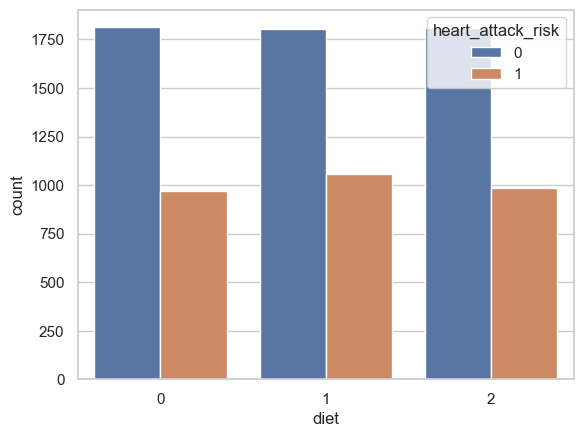

In [45]:
sns.countplot(heart_train, x='diet', hue='heart_attack_risk')

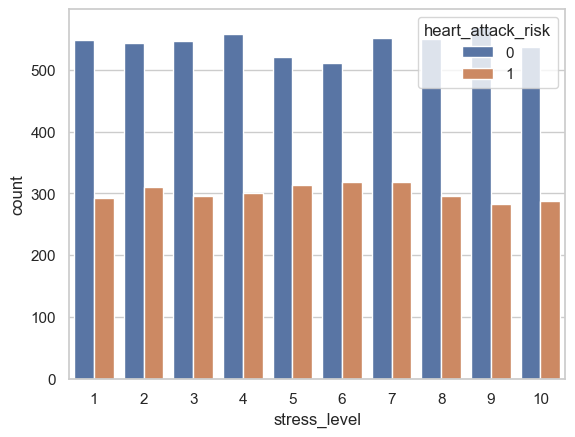

In [46]:
sns.countplot(heart_train, x='stress_level', hue='heart_attack_risk');

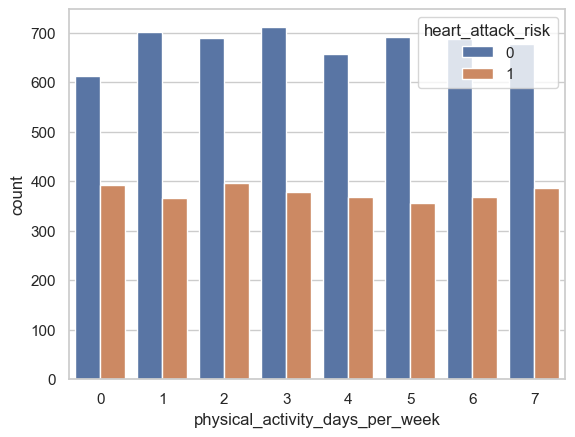

In [47]:
sns.countplot(heart_train, x='physical_activity_days_per_week', hue='heart_attack_risk');

Какой-то вывод

# Модель

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    heart_train.drop(['heart_attack_risk', 'unnamed_0', 'id'], axis=1),
    heart_train['heart_attack_risk'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)
X_train.shape, X_test.shape

((6331, 25), (2111, 25))

In [49]:
object_features = ['gender']

In [50]:
# model = CatBoostClassifier(random_state=RANDOM_STATE, 
#                            cat_features = object_features, 
#                            )

In [51]:
pool_train = Pool(X_train, y_train, cat_features=object_features)
pool_test = Pool(X_test, y_test, cat_features=object_features)

In [52]:
# params = {
#     'iterations': [400, 600, 800],
#     'depth': [2, 4, 6],
#     'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.15],
#     'l2_leaf_reg': [3, 5, 7]
# }

In [53]:
# result = model.randomized_search(
#     params,
#     pool_train,
#     cv=3,                          
#     partition_random_seed=RANDOM_STATE     
# )

In [54]:
# result['params']

In [104]:
model = CatBoostClassifier(random_state=RANDOM_STATE, 
                           cat_features = object_features, 
                           iterations=800,
                           learning_rate=0.1,
                           class_weights=[1, 8]
                           )
model.fit(pool_train)

0:	learn: 0.6484805	total: 2.95ms	remaining: 2.35s
1:	learn: 0.6129748	total: 5.64ms	remaining: 2.25s
2:	learn: 0.5848820	total: 8.3ms	remaining: 2.2s
3:	learn: 0.5627258	total: 11ms	remaining: 2.19s
4:	learn: 0.5445188	total: 13.7ms	remaining: 2.17s
5:	learn: 0.5300374	total: 16.3ms	remaining: 2.16s
6:	learn: 0.5188161	total: 19ms	remaining: 2.16s
7:	learn: 0.5094039	total: 21.8ms	remaining: 2.16s
8:	learn: 0.5021356	total: 24.5ms	remaining: 2.15s
9:	learn: 0.4963734	total: 27.1ms	remaining: 2.14s
10:	learn: 0.4912999	total: 29.7ms	remaining: 2.13s
11:	learn: 0.4874834	total: 32.4ms	remaining: 2.13s
12:	learn: 0.4840423	total: 35.1ms	remaining: 2.12s
13:	learn: 0.4808438	total: 37.8ms	remaining: 2.12s
14:	learn: 0.4781426	total: 40.6ms	remaining: 2.12s
15:	learn: 0.4753935	total: 43.3ms	remaining: 2.12s
16:	learn: 0.4736494	total: 45.9ms	remaining: 2.12s
17:	learn: 0.4723623	total: 48.6ms	remaining: 2.11s
18:	learn: 0.4708078	total: 51.3ms	remaining: 2.11s
19:	learn: 0.4694396	total: 

In [ ]:
# best_model = CatBoostClassifier(**result['params'])
# best_model.fit(pool_train)
# best_model.predict(pool_test)

In [105]:
pd.DataFrame(classification_report(y_test, model.predict(X_test), output_dict=True)).T

,precision,recall,f1-score,support
0,0.717355,0.322677,0.445128,1345.000000
1,0.395086,0.776762,0.523768,766.000000
accuracy,0.487447,0.487447,0.487447,0.487447
macro avg,0.556221,0.549719,0.484448,2111.000000
weighted avg,0.600416,0.487447,0.473663,2111.000000


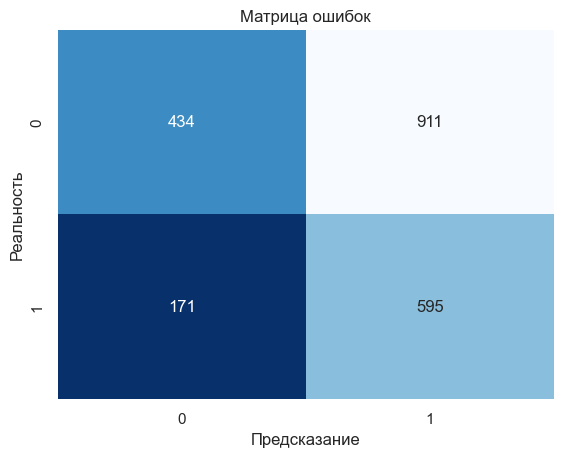

In [107]:
sns.heatmap(confusion_matrix(y_test, model.predict(pool_test)), annot=True, fmt='d', cbar=False, cmap='Blues_r')
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')
plt.show()

Увеличилось количество ошибок модели 1 рода. В связи с этим можно дать рекомендацию проводить меры профилактики напревленные на предотвращение сердечно-сосудистых заболеваний

In [108]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,exercise_hours_per_week,8.736803
1,triglycerides,8.400354
2,bmi,7.934559
3,age,7.588858
4,cholesterol,7.487096
5,systolic_blood_pressure,7.424402
6,diastolic_blood_pressure,7.304026
7,income,7.231976
8,sedentary_hours_per_day,7.159988
9,heart_rate,6.616885


In [109]:
perm = permutation_importance(model, X_test, y_test, scoring = 'f1', n_repeats=20,
                                random_state=123)

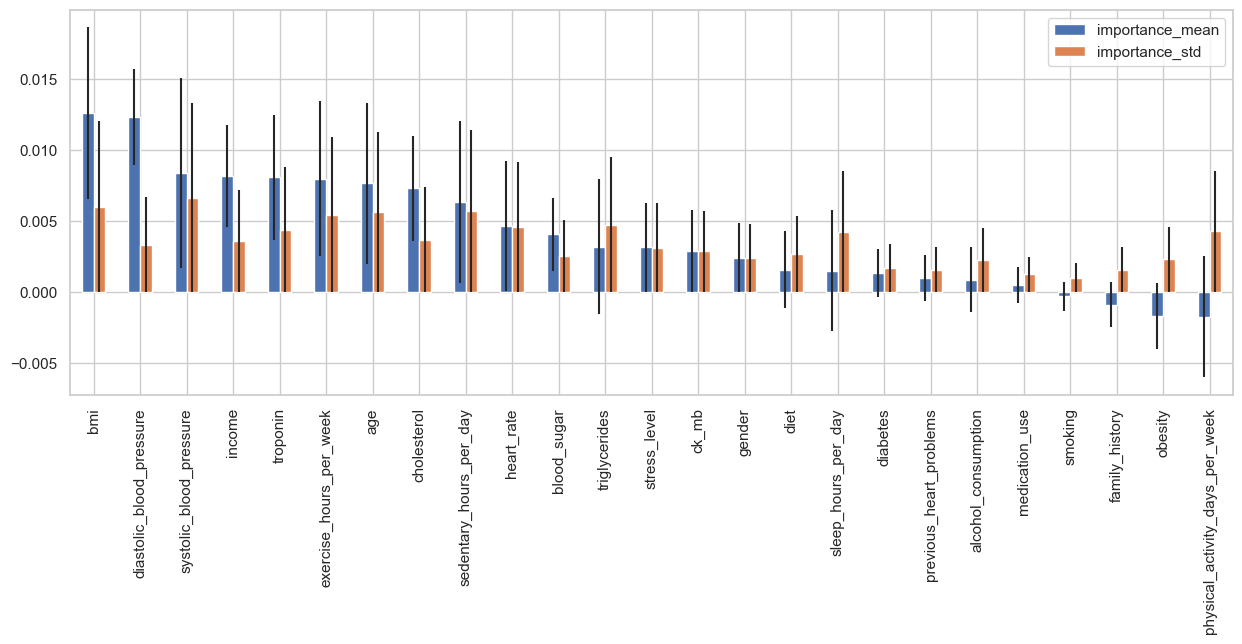

In [110]:
perm = pd.DataFrame(
    {"importance_mean": perm["importances_mean"],
     "importance_std": perm["importances_std"]},
    index=model.feature_names_)
perm.sort_values('importance_mean', ascending=False).plot(figsize=(15, 5), kind="bar", yerr=perm["importance_std"]);

Какие признаки модель определяет важными

In [122]:
importance_features = ['bmi', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'income', 'exercise_hours_per_week', 'age',
                       'cholesterol', 'sedentary_hours_per_day', 'triglycerides', 'heart_rate']

Минимизировали ошибку первого рода, но увеличилось значение ошибки второго рода. Проводить профилактику сердечно-сосудистых заболеваний. Важно не пропустить пациентов с высоким риском сердечного приступа.

# Предсказания на тесте

In [113]:
heart_test = pd.read_csv('heart_test.csv')
heart_test.head(5)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [114]:
heart_test.columns = [col.lower().replace(' ', '_').replace(':', '').replace('-', '_') for col in heart_test.columns]

In [115]:
predicts = model.predict(heart_test.drop(['unnamed_0', 'id'], axis=1))

In [116]:
heart_test_pred = pd.concat([heart_test['id'], pd.Series(predicts)], axis=1
)
heart_test_pred.rename(columns={0: 'predict'}, inplace=True)
heart_test_pred

,id,predict
0,7746,1
1,4202,0
2,6632,1
3,4639,0
4,4825,1
...,...,...
961,9271,1
962,8012,1
963,2456,1
964,4984,0


In [120]:
heart_test_pred.to_csv('heart_test_pred.csv', index=False)

# Prod

In [123]:
df = heart_train[importance_features]

In [124]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    df,
    heart_train['heart_attack_risk'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [126]:
catboost = CatBoostClassifier(random_state=RANDOM_STATE,  
                           iterations=800,
                           learning_rate=0.1,
                           class_weights=[1, 8]
                           )
catboost.fit(X_train_1, y_train_1)

0:	learn: 0.6485815	total: 2.79ms	remaining: 2.23s
1:	learn: 0.6132052	total: 5.33ms	remaining: 2.13s
2:	learn: 0.5851513	total: 7.97ms	remaining: 2.12s
3:	learn: 0.5627871	total: 10.7ms	remaining: 2.12s
4:	learn: 0.5446547	total: 13.2ms	remaining: 2.1s
5:	learn: 0.5303043	total: 15.8ms	remaining: 2.09s
6:	learn: 0.5186352	total: 18.3ms	remaining: 2.07s
7:	learn: 0.5097728	total: 20.9ms	remaining: 2.06s
8:	learn: 0.5025002	total: 23.4ms	remaining: 2.06s
9:	learn: 0.4964755	total: 26.1ms	remaining: 2.06s
10:	learn: 0.4916230	total: 28.6ms	remaining: 2.05s
11:	learn: 0.4876060	total: 31.2ms	remaining: 2.05s
12:	learn: 0.4845361	total: 33.7ms	remaining: 2.04s
13:	learn: 0.4818688	total: 36.3ms	remaining: 2.04s
14:	learn: 0.4796828	total: 38.8ms	remaining: 2.03s
15:	learn: 0.4780048	total: 41.4ms	remaining: 2.03s
16:	learn: 0.4765942	total: 44ms	remaining: 2.03s
17:	learn: 0.4752246	total: 46.5ms	remaining: 2.02s
18:	learn: 0.4739580	total: 49.1ms	remaining: 2.02s
19:	learn: 0.4729913	tota

In [127]:
pd.DataFrame(classification_report(y_test_1, catboost.predict(X_test_1), output_dict=True)).T

,precision,recall,f1-score,support
0,0.683186,0.286989,0.404188,1345.000000
1,0.379690,0.766319,0.507785,766.000000
accuracy,0.460919,0.460919,0.460919,0.460919
macro avg,0.531438,0.526654,0.455987,2111.000000
weighted avg,0.573059,0.460919,0.441780,2111.000000


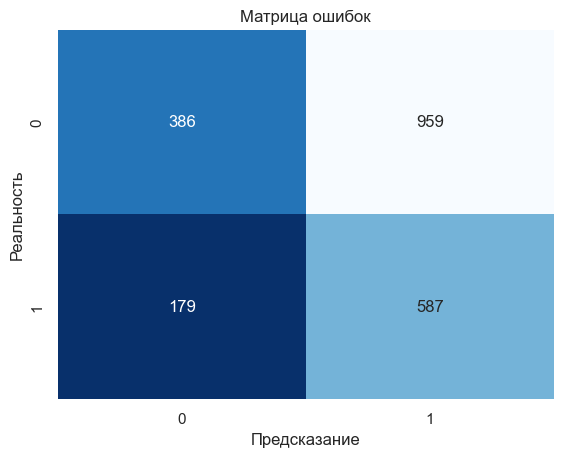

In [128]:
sns.heatmap(confusion_matrix(y_test, catboost.predict(X_test_1)), annot=True, fmt='d', cbar=False, cmap='Blues_r')
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')
plt.show()

# Сохранение модели

In [129]:
with open('model.plk', 'wb') as fid:
    pickle.dump(catboost, fid)

# Инференс

In [130]:
with open('model.plk', 'rb') as fid:
    test_model = pickle.load(fid)

In [131]:
data = heart_test[importance_features].loc[962]

In [132]:
pred = test_model.predict(data)
print(pred)

1
